# Assignment : Lending Club Case Study

Team : Vijay Garg and Santhosh ankam

Date : 14 Feb 2021

# Business Understanding

We are working for Lending club a finance company which specialises in lending various types of loans to urban customers. When the company receives a loan application, the company has to make a decision for loan approval based on the applicant’s profile. Two types of risks are associated with the bank’s decision:
•If the applicant is likely to repay the loan, then not approving the loan results in a loss of business to the company
•If the applicant is not likely to repay the loan, i.e. he/she is likely to default, then approving the loan may lead to a financial loss for the company


# Objective

The company wants to understand the driving factors (or driver variables) behind loan default (loan_status = 'Charged Off'), i.e. the variables which are strong indicators of default. The company can utilise this knowledge for its portfolio and risk assessment.


Import the necessary libraries

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.core.display import HTML
%matplotlib inline
warnings.filterwarnings('ignore') # if there are any warning due to version mismatch, it will be ignored

In [3]:
#since we already created one local copy, we can start working on actual data for our Analysis
loan= pd.read_csv('C:/Users/PC/Desktop/Upgrad/Club Lending assignment/loan/loan.csv')

In [4]:
# exploring the data using various parameters.
loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,Unnamed: 111,Unnamed: 112
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 113 entries, id to Unnamed: 112
dtypes: float64(76), int64(13), object(24)
memory usage: 34.2+ MB


In [6]:
loan.shape

(39717, 113)

In [7]:
#as we see some columns have missing values and unique values, let see explore more to keep or drop them
#Let us do some cleanup of NULLs from rows and columns of the loan dataframe


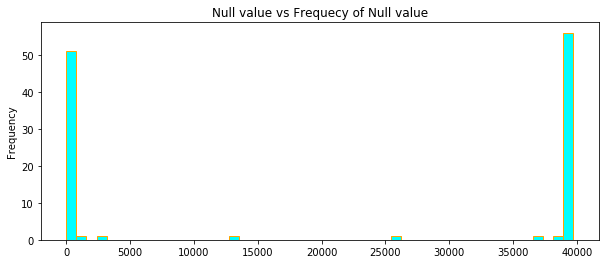

In [10]:
c = loan.isnull().sum()
c.plot(kind='hist', bins=50, figsize = (10,4),edgecolor="orange",color="cyan")
plt.title("Null value vs Frequecy of Null value")
plt.show()

#In the above figure, X-axis contains number of NULL values and Y-axis contains number of columns. We can clearly see that there is a huge spike towards the 40K mark. The total records in our data is 39,717. We would obviously not need the columns that have all NULLs. Also, we see there are few columns above 10K mark, but let us analyze those before dropping.


In [11]:
c.loc[(c.values > 10000) & (c.values < 39717)].sort_values()

desc                      12940
mths_since_last_delinq    25682
mths_since_last_record    36931
next_pymnt_d              38577
dtype: int64

Let us drop all columns having above 10K NULL values in them.

In [12]:
loan.drop(columns=list(c[c.values > 10000].index), inplace=True)
loan.shape

(39717, 53)

# so we dropped those columns with missing data

In [13]:
r = loan.isnull().sum(axis=1) / len(loan.columns)
max(r.values)

0.09433962264150944

Let us see if there are any columns with unique or single values in them.

In [14]:
column_unique = loan.nunique()
print(column_unique)

id                            39717
member_id                     39717
loan_amnt                       885
funded_amnt                    1041
funded_amnt_inv                8205
term                              2
int_rate                        371
installment                   15383
grade                             7
sub_grade                        35
emp_title                     28820
emp_length                       11
home_ownership                    5
annual_inc                     5318
verification_status               3
issue_d                          55
loan_status                       3
pymnt_plan                        1
url                           39717
purpose                          14
title                         19615
zip_code                        823
addr_state                       50
dti                            2868
delinq_2yrs                      11
earliest_cr_line                526
inq_last_6mths                    9
open_acc                    

we can actually look at those columns with single value and drop them as they will be no use for our analysis

In [15]:
c1 = column_unique[column_unique.values == 1]
c1.index

Index(['pymnt_plan', 'initial_list_status', 'collections_12_mths_ex_med',
       'policy_code', 'application_type', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens'],
      dtype='object')

drop above columns with values "1"

In [16]:
loan.drop(columns = list(c1.index), inplace=True)
loan.shape

(39717, 44)

from 111 columns , we came down to 44 with same number of rows so far...

The company wants to know which loan applications are risky. Therefore, the fields that are created after a loan application is approved doesn't make sense for our analysis towards the business objective. Secondly, fields like id, member_id & url are different for each application. zip_code could have been a useful driver, but it contains only partial data which might impute our analysis negatively. Therefore, let us drop all these columns mentioned below

In [17]:
del_cols = ["id","member_id","url","zip_code","out_prncp","out_prncp_inv","total_pymnt","total_pymnt_inv",
            "total_rec_prncp","total_rec_int","total_rec_late_fee","recoveries","collection_recovery_fee",
            "last_pymnt_d","last_pymnt_amnt","last_credit_pull_d"]
loan.drop(columns=del_cols, inplace=True)
loan.shape

(39717, 28)

In [18]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 28 columns):
loan_amnt               39717 non-null int64
funded_amnt             39717 non-null int64
funded_amnt_inv         39717 non-null float64
term                    39717 non-null object
int_rate                39717 non-null object
installment             39717 non-null float64
grade                   39717 non-null object
sub_grade               39717 non-null object
emp_title               37258 non-null object
emp_length              38642 non-null object
home_ownership          39717 non-null object
annual_inc              39717 non-null float64
verification_status     39717 non-null object
issue_d                 39717 non-null object
loan_status             39717 non-null object
purpose                 39717 non-null object
title                   39706 non-null object
addr_state              39717 non-null object
dti                     39717 non-null float64
delinq_2yrs    

In [19]:
loan.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,pub_rec_bankruptcies
count,39717.000000,39717.000000,39717.000000,39717.000000,3.971700e+04,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39020.000000
mean,11219.443815,10947.713196,10397.448868,324.561922,6.896893e+04,13.315130,0.146512,0.869200,9.294408,0.055065,13382.528086,22.088828,0.043260
std,7456.670694,7187.238670,7128.450439,208.874874,6.379377e+04,6.678594,0.491812,1.070219,4.400282,0.237200,15885.016641,11.401709,0.204324
min,500.000000,500.000000,0.000000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,0.000000
25%,5500.000000,5400.000000,5000.000000,167.020000,4.040400e+04,8.170000,0.000000,0.000000,6.000000,0.000000,3703.000000,13.000000,0.000000
50%,10000.000000,9600.000000,8975.000000,280.220000,5.900000e+04,13.400000,0.000000,1.000000,9.000000,0.000000,8850.000000,20.000000,0.000000
75%,15000.000000,15000.000000,14400.000000,430.780000,8.230000e+04,18.600000,0.000000,1.000000,12.000000,0.000000,17058.000000,29.000000,0.000000
max,35000.000000,35000.000000,35000.000000,1305.190000,6.000000e+06,29.990000,11.000000,8.000000,44.000000,4.000000,149588.000000,90.000000,2.000000


### Data preparation 
let us start with loan status columns to begin with

In [20]:
loan['loan_status'].value_counts()

Fully Paid     32950
Charged Off     5627
Current         1140
Name: loan_status, dtype: int64

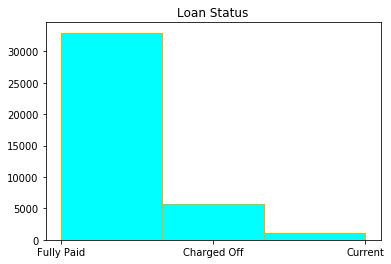

In [21]:
plt.hist(loan['loan_status'],bins=3,edgecolor="orange",color="cyan")
plt.title("Loan Status")
plt.show()

Since loan status "Current" doesnt give any info for our analysis for approving or rejecting application, so dropping this data makes sense

In [22]:
loan = loan[~(loan['loan_status'] == 'Current')]
loan.shape

(38577, 28)

Let us look at other columns for our analysis... take term and see how it can infulence our decision manking..

In [23]:
loan['term'].value_counts()

 36 months    29096
 60 months     9481
Name: term, dtype: int64

In [24]:
loan['int_rate'].head()

0    10.65%
1    15.27%
2    15.96%
3    13.49%
5     7.90%
Name: int_rate, dtype: object

In [25]:
#Let's remvoe %
loan['int_rate'] = loan['int_rate'].apply(lambda x: pd.to_numeric(x.split("%")[0]))
loan['int_rate'].describe()

count    38577.000000
mean        11.932219
std          3.691327
min          5.420000
25%          8.940000
50%         11.710000
75%         14.380000
max         24.400000
Name: int_rate, dtype: float64

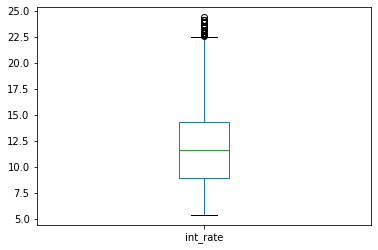

In [26]:
loan['int_rate'].plot.box()
plt.show()

we can see some outlier values in int_rate column which needs to analysed when we do univariate analysis

In [115]:
loan['grade'].value_counts()

B    11675
A    10045
C     7834
D     5085
E     2663
F      976
G      299
Name: grade, dtype: int64

In [116]:
loan['sub_grade'].value_counts()

A4    2873
B3    2825
A5    2715
B5    2615
B4    2437
C1    2055
B2    2001
C2    1931
A3    1810
B1    1797
A2    1508
C3    1488
D2    1286
C4    1206
C5    1154
A1    1139
D3    1116
D1     931
D4     918
D5     834
E1     722
E2     614
E3     516
E4     424
E5     387
F1     305
F2     233
F3     174
F4     151
F5     113
G1      94
G2      77
G4      54
G3      45
G5      29
Name: sub_grade, dtype: int64

In [117]:
print(loan['emp_title'].value_counts().head())
print(loan['emp_title'].unique().shape)

US Army              131
Bank of America      107
IBM                   65
AT&T                  57
Kaiser Permanente     56
Name: emp_title, dtype: int64
(28028,)


In [118]:
loan['emp_length'].unique()

array(['10+ years', '< 1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '1 year', '6 years', '2 years', '7 years',
       nan], dtype=object)

In [119]:
loan['emp_length'].isnull().sum()

1033

In [120]:
loan.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'title', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'pub_rec_bankruptcies'],
      dtype='object')

In [121]:
loan['home_ownership'].value_counts()

RENT        18480
MORTGAGE    17021
OWN          2975
OTHER          98
NONE            3
Name: home_ownership, dtype: int64

In [122]:
loan['verification_status'].value_counts()

Not Verified       16694
Verified           12206
Source Verified     9677
Name: verification_status, dtype: int64

In [123]:
loan['issue_d'].head()

0    Dec-11
1    Dec-11
2    Dec-11
3    Dec-11
5    Dec-11
Name: issue_d, dtype: object

let's split the month and year

In [124]:
m, y = loan['issue_d'].str.split('-').str

In [125]:
y.value_counts()

11    20516
10    11532
09     4716
08     1562
07      251
Name: issue_d, dtype: int64

In [126]:
m.value_counts()

Dec    4215
Nov    4006
Oct    3761
Sep    3498
Aug    3388
Jul    3351
Jun    3180
May    2919
Apr    2831
Mar    2691
Jan    2379
Feb    2358
Name: issue_d, dtype: int64

let us add new column like issued_year and issued_month which will be useful for our further analysis and drop this issue_d column


In [127]:
loan['issue_y'] = pd.to_numeric(y)
loan['issue_m'] = m
loan.drop(columns=['issue_d'], inplace=True)

In [128]:
loan.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,issue_y,issue_m
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,...,Jan-85,1,3,0,13648,83.70%,9,0.0,11,Dec
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,...,Apr-99,5,3,0,1687,9.40%,4,0.0,11,Dec
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,...,Nov-01,2,2,0,2956,98.50%,10,0.0,11,Dec
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,Feb-96,1,10,0,5598,21%,37,0.0,11,Dec
5,5000,5000,5000.0,36 months,7.90,156.46,A,A4,Veolia Transportaton,3 years,...,Nov-04,3,9,0,7963,28.30%,12,0.0,11,Dec


In [129]:
loan['purpose'].value_counts()

debt_consolidation    18055
credit_card            5027
other                  3865
home_improvement       2875
major_purchase         2150
small_business         1754
car                    1499
wedding                 926
medical                 681
moving                  576
vacation                375
house                   367
educational             325
renewable_energy        102
Name: purpose, dtype: int64

In [130]:
len(loan['title'].value_counts())

19297

In [131]:
loan['title'].head(10)

0                                  Computer
1                                      bike
2                      real estate business
3                                  personel
5     My wedding loan I promise to pay back
6                                      Loan
7                           Car Downpayment
8      Expand Business & Buy Debt Portfolio
9               Building my credit history.
10               High intrest Consolidation
Name: title, dtype: object

In [132]:
loan['title'].sample(10)

30452                 Dumping Debt
10911                     W8TN4CHG
29864        betafinance refinance
19938    Dave's Consolidation Loan
7893                  Free at Last
26003                Consolidation
14317            debt consolidaton
38392       Decrease utility bills
37048           Retirement funding
11652               hard luck loan
Name: title, dtype: object

since title column has too many unique values... let us drop this column as it may not be useful to keep it 

In [133]:
loan.drop(columns=['title'], inplace=True)

In [134]:
loan['addr_state'].value_counts()

CA    6949
NY    3698
FL    2781
TX    2659
NJ    1790
IL    1478
PA    1468
VA    1369
GA    1359
MA    1297
OH    1178
MD    1023
AZ     849
WA     818
CO     766
NC     750
CT     726
MI     704
MO     670
MN     605
NV     479
SC     459
WI     440
AL     435
OR     435
LA     427
KY     311
OK     287
KS     255
UT     252
AR     235
DC     211
RI     194
NM     183
WV     172
NH     166
HI     166
DE     113
MT      83
WY      80
AK      78
SD      62
VT      53
MS      19
TN      17
IN       9
ID       6
IA       5
NE       5
ME       3
Name: addr_state, dtype: int64

In [135]:
loan['earliest_cr_line'].value_counts()

Oct-99    360
Nov-98    357
Oct-00    341
Dec-98    340
Dec-97    318
         ... 
Jun-59      1
Mar-68      1
Sep-56      1
Sep-63      1
Oct-69      1
Name: earliest_cr_line, Length: 524, dtype: int64

In [136]:
m, y = loan['earliest_cr_line'].str.split('-').str
y.value_counts()

00    3160
99    2896
98    2773
01    2462
97    2387
96    2202
95    2078
94    1948
02    1890
03    1813
04    1727
05    1467
93    1460
06    1154
92    1029
90    1005
91     945
89     834
88     709
07     698
87     590
86     478
85     439
84     395
83     322
82     215
81     181
80     175
78     161
79     157
08     153
77     112
76      93
75      83
74      62
73      61
72      49
70      47
71      45
69      37
68      19
67      18
66      11
63      10
65       8
64       6
62       5
61       2
54       2
50       1
46       1
59       1
56       1
Name: earliest_cr_line, dtype: int64

In the earliest_cr_line field, we do see some data format inconsistencies. Sometimes it has MMM-YY and at other times it has YY-MMM. Also, the year is a 2 digit and not Y2K corrected. Therefre, we would need to apply some logic to extract meaningful data from here

In [137]:
from datetime import datetime
today = datetime.today()
today.year

2021

In [138]:
def days_from_earliest_cr_line (d):
    m, y = d.split('-')
    if y in ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']:
        y, m = d.split('-')
    y = 2000 + int(y)
    if y > today.year:
        y -= 100
    earliest_cr_line = datetime.strptime(str(y)+'-'+m+'-1', '%Y-%b-%d')
    return (today - earliest_cr_line).days
days_from_earliest_cr_line("Dec-20")

83

In [139]:
loan['days_from_earliest_cr_line'] = loan['earliest_cr_line'].apply(days_from_earliest_cr_line)
loan['days_from_earliest_cr_line'].describe()

count    38577.000000
mean      8783.981647
std       2491.854695
min       4496.000000
25%       7114.000000
50%       8333.000000
75%       9945.000000
max      27446.000000
Name: days_from_earliest_cr_line, dtype: float64

In [140]:
loan.drop(columns=['earliest_cr_line'], inplace=True)

In [141]:
loan['revol_util'].head()

0    83.70%
1     9.40%
2    98.50%
3       21%
5    28.30%
Name: revol_util, dtype: object

In [142]:
#let us convert these values in numberics by removing %
loan['revol_util'] = pd.Series(loan['revol_util']).str.replace('%', '').astype(float)
loan['revol_util'].describe()

count    38527.000000
mean        48.702777
std         28.364741
min          0.000000
25%         25.200000
50%         49.100000
75%         72.300000
max         99.900000
Name: revol_util, dtype: float64

In [143]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   38577 non-null  int64  
 1   funded_amnt                 38577 non-null  int64  
 2   funded_amnt_inv             38577 non-null  float64
 3   term                        38577 non-null  object 
 4   int_rate                    38577 non-null  float64
 5   installment                 38577 non-null  float64
 6   grade                       38577 non-null  object 
 7   sub_grade                   38577 non-null  object 
 8   emp_title                   36191 non-null  object 
 9   emp_length                  37544 non-null  object 
 10  home_ownership              38577 non-null  object 
 11  annual_inc                  38577 non-null  float64
 12  verification_status         38577 non-null  object 
 13  loan_status                 385

In [144]:
loan.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,issue_y,days_from_earliest_cr_line
count,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,3.857700e+04,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,38527.000000,38577.000000,37880.000000,38577.000000,38577.000000
mean,11047.025430,10784.058506,10222.481123,11.932219,322.466318,6.877797e+04,13.272727,0.146668,0.871737,9.275423,0.055422,13289.489826,48.702777,22.052648,0.043479,10.309070,8783.981647
std,7348.441646,7090.306027,7022.720644,3.691327,208.639215,6.421868e+04,6.673044,0.492271,1.071546,4.401588,0.237804,15866.492241,28.364741,11.425861,0.204583,0.882658,2491.854695
min,500.000000,500.000000,0.000000,5.420000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,7.000000,4496.000000
25%,5300.000000,5200.000000,5000.000000,8.940000,165.740000,4.000000e+04,8.130000,0.000000,0.000000,6.000000,0.000000,3650.000000,25.200000,13.000000,0.000000,10.000000,7114.000000
50%,9600.000000,9550.000000,8733.440000,11.710000,277.860000,5.886800e+04,13.370000,0.000000,1.000000,9.000000,0.000000,8762.000000,49.100000,20.000000,0.000000,11.000000,8333.000000
75%,15000.000000,15000.000000,14000.000000,14.380000,425.550000,8.200000e+04,18.560000,0.000000,1.000000,12.000000,0.000000,16912.000000,72.300000,29.000000,0.000000,11.000000,9945.000000
max,35000.000000,35000.000000,35000.000000,24.400000,1305.190000,6.000000e+06,29.990000,11.000000,8.000000,44.000000,4.000000,149588.000000,99.900000,90.000000,2.000000,11.000000,27446.000000


Let us now take the percentage of loans paid vs charged off for all the records before going into further analysis

In [145]:
loan_status_percent = loan['loan_status'].value_counts(normalize=True)
loan_status_percent

Fully Paid     0.854136
Charged Off    0.145864
Name: loan_status, dtype: float64

# since we have cleaned data set and have parameters for our EDA. let's proceed with EDA


Univariate Analysis

Let us start by understanding the correlation between the different numeric fields and see if they are related (high correlation values)


In [146]:
# changing the loan_status to a numeric variable, assign 1 for defaulted loans and 0 for paid off ones
loan['loan_status_num'] = loan['loan_status'].apply(lambda x: 1 if x=='Charged Off' else 0)

In [147]:
loan.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,issue_y,issue_m,days_from_earliest_cr_line,loan_status_num
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,...,3,0,13648,83.7,9,0.0,11,Dec,13201,0
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,...,3,0,1687,9.4,4,0.0,11,Dec,7998,1
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,...,2,0,2956,98.5,10,0.0,11,Dec,7053,0
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,10,0,5598,21.0,37,0.0,11,Dec,9153,0
5,5000,5000,5000.0,36 months,7.90,156.46,A,A4,Veolia Transportaton,3 years,...,9,0,7963,28.3,12,0.0,11,Dec,5957,0


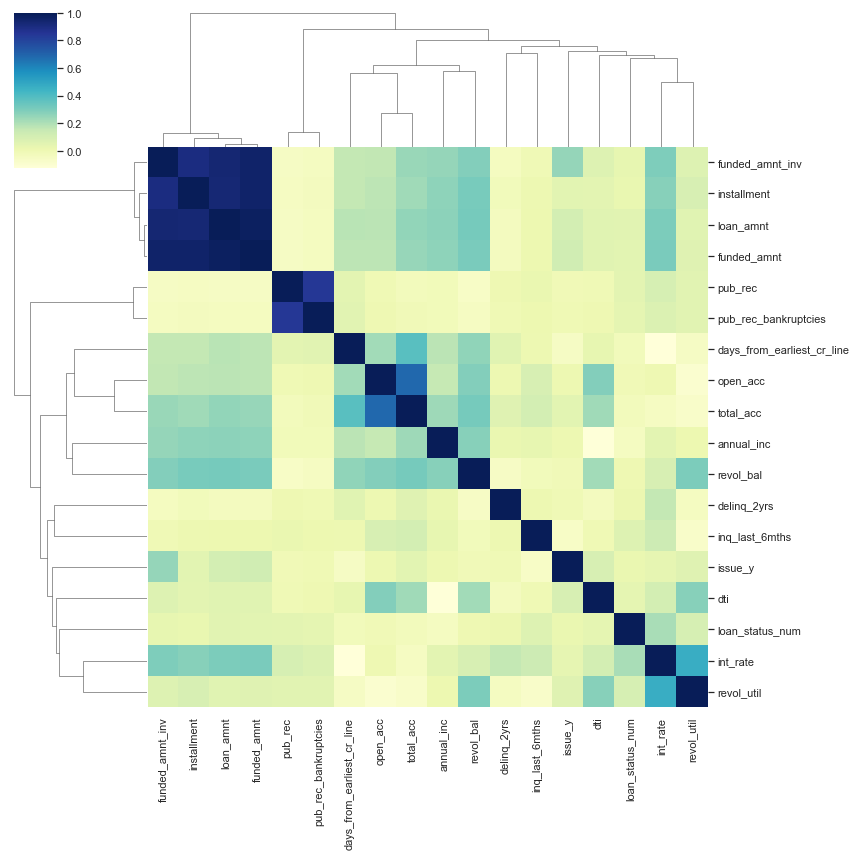

In [148]:
sns.set_style("whitegrid")
sns.clustermap(data=loan.corr(), cmap='YlGnBu', figsize=(12,12))
plt.show()

Since we know darker the value heigher the correlation , we can clearly see loan_amnt, funded_amnt, funded_amnt_inv and installment have huge correlation
 These fields are proportional to each other. Next, the public records related fields pub_rec & pub_rec_bankrupcies and number of accounts related fields open_acc & total_acc are correlated.

# Loan status vs Numerical continuous variables

Let us now compare the loan_status fields with all the numerical variable. Since the analysis for this category will be similar, let us contruct a common function which can be used for all.


In [185]:
# here are some of the global settings/constants that will be referred to within the functions defined below
#colors = ["#fca9a9","#a9fea9"]
colors = ["#a9fea9","#fca9a9"]
sns.set(style='whitegrid', palette=sns.color_palette(colors))
by = 'loan_status'
order = ['Fully Paid','Charged Off']
# loan_status_pct from above will be used in the below functions as well

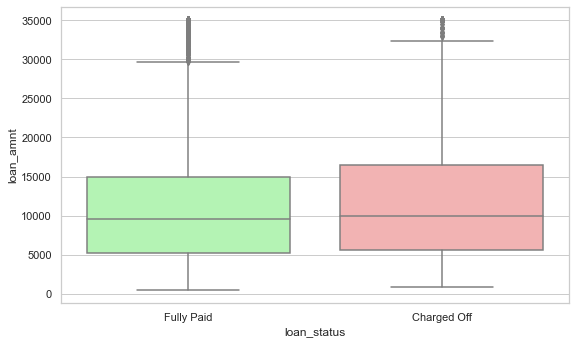

In [186]:
plt.figure(figsize=(20, 12))
plt.subplot(2,2,1)
sns.boxplot(x = 'loan_status', y = 'loan_amnt', data = loan)
plt.show()

In [151]:
loan['loan_amnt'].describe()

count    38577.000000
mean     11047.025430
std       7348.441646
min        500.000000
25%       5300.000000
50%       9600.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

since we see there is huge difference between mean and median . let us limit our data to 75%

In [152]:
loan_till75 = loan.loc[(loan['loan_amnt']<=15000)]

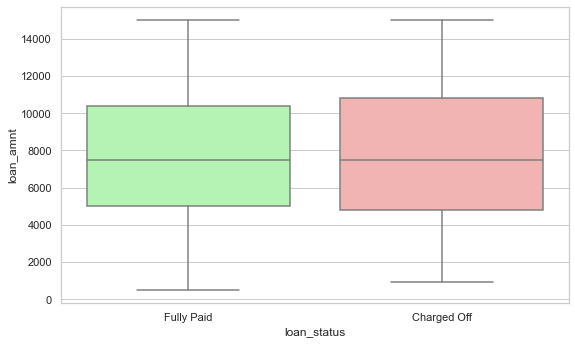

In [153]:
plt.figure(figsize=(20, 12))
plt.subplot(2,2,1)
sns.boxplot(x = 'loan_status', y = 'loan_amnt', data = loan_till75)
plt.show()

since it is giving picture , let us take date data above 75%

In [154]:
loan_above75 = loan.loc[(loan['loan_amnt']>=15000)]
loan_above75.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,issue_y,issue_m,days_from_earliest_cr_line,loan_status_num
20,20250,20250,19142.16108,60 months,15.27,484.63,C,C4,Archdiocese of Galveston Houston,3 years,...,8,0,17813,85.6,22,0.0,11,Dec,8514,0
21,21000,21000,21000.00000,36 months,12.42,701.73,B,B4,Osram Sylvania,10+ years,...,7,0,32135,90.3,38,0.0,11,Dec,13901,1
25,15000,15000,15000.00000,36 months,9.91,483.38,B,B1,Winfield Pathology Consultants,2 years,...,8,0,13707,93.9,31,0.0,11,Dec,6961,0
26,15000,15000,8725.00000,36 months,14.27,514.64,C,C2,nyc transit,9 years,...,7,0,5872,57.6,11,0.0,11,Dec,6354,1
31,31825,31825,31825.00000,36 months,7.90,995.82,A,A4,Audubon Mutual Housing Corporation,5 years,...,12,0,23151,27.4,26,0.0,11,Dec,14358,0


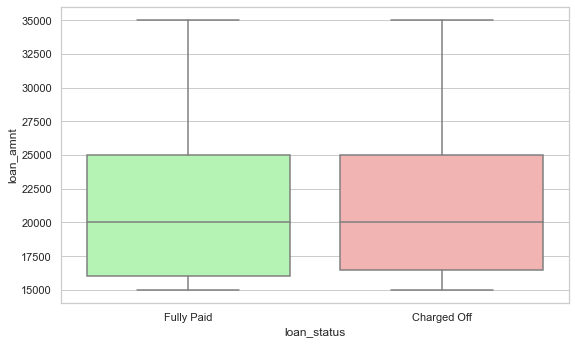

In [155]:
plt.figure(figsize=(20, 12))
plt.subplot(2,2,1)
sns.boxplot(x = 'loan_status', y = 'loan_amnt', data = loan_above75)
plt.show()

### from above box plot we can conclude that "heigher the amount" will tend to "Write off"

since we have too many columns for univariate analysis let us define some default functions, so that we can re-use same function
for all the columns 

In [156]:
def PercentileCut (*, data=loan, column, trailer=''):
    """
        Parameters:
            data : defaulted to 'loan'
            column : this is the continuous numeric field which has to be binned to its percentiles
            trailer : defaulted to blank, this will be added to the end of the percentile values
                      like '%' for interest rate related fields
        Returns:
            None
            It creates a new column in the data with a suffix '_p' and this contains the newly created category
    """
    new_column = column + '_p'
    labels = ['Lowest ','Lower ','Medium ','Higher ','Highest ']
    labels = [labels[p] + '(' +
              str(round(np.nanpercentile(data[column], p * 20),2)) +
              trailer + ' - ' +
              str(round(np.nanpercentile(data[column], (p+1) * 20),2)) +
              trailer + ')'
              for p in range(5)]
    data[new_column] = pd.qcut(data[column], q=5, labels=labels)

In [157]:
loan.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'pub_rec_bankruptcies', 'issue_y', 'issue_m',
       'days_from_earliest_cr_line', 'loan_status_num'],
      dtype='object')

In [158]:
def Univariate_Categorical (*, data=loan, column, title=None, figsize=(8,6), grp_comparison=True, box_plot=False,
                            pct_comparison=False, filter=None, disp_filter = None):
    """
        Parameters:
            data : defaulted at the 'loan' variable, but can be changed externally if needed
            column : need to provide the numerical column for comparison
            figsize : a default have is given, but can be overridden
            loan_status_pct : a global variable, which is referred here for the percentage comparison
            grp_comparison : with this as true, it groups the data based on the categories and compares
            pct_comparison : this will call the Pct_Comparison method and below couple parameters will be applicable for it
            filter : any conditions based on which the data will be filtered before plotting, ignored if None
            disp_filter : string for display purpose only, valid if filter is not None
        Returns:
            None, does a countplot and a box plot as well, if needed
    """
    plotdata = data if filter is None else data.loc[filter]
        
    if pct_comparison and filter is not None:
        Pct_Comparison(filter, disp_filter)

    if grp_comparison:
        fig, ax = plt.subplots(figsize=figsize)
        sns.countplot(data=plotdata, y=column, hue=by, ax=ax, 
                      order=plotdata[column].value_counts().index, hue_order=order)
        if title is not None:
            plt.title(title)
        plt.show()
        
        df = loan.groupby([column])[by].value_counts(normalize=True
                                                    ).rename('Charged off %').reset_index().sort_values(column)
        df = df.loc[df[by]=='Charged Off'].sort_values(by='Charged off %', ascending=False).drop(columns=[by])
        df2 = loan.groupby([column])[by].count()
        df = df.merge(right=df2,on=column).rename(columns={by:'Record count'})
        display(HTML(df.to_html(index=False)))
        
        if box_plot:
            df2.plot(kind='box',logy=True,x="No. of records of defaulted loans per category")
            plt.show()        

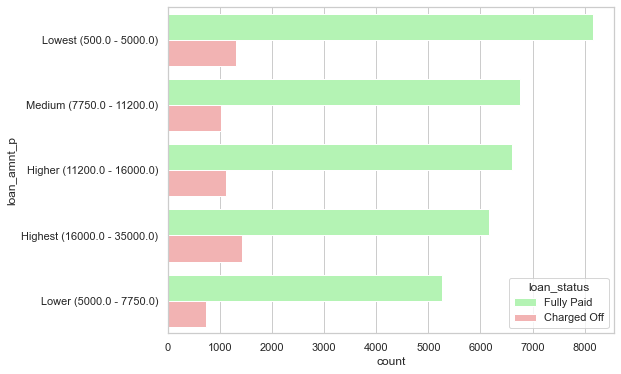

loan_amnt_p,Charged off %,Record count
Highest (16000.0 - 35000.0),0.187624,7579
Higher (11200.0 - 16000.0),0.145368,7739
Lowest (500.0 - 5000.0),0.138725,9472
Medium (7750.0 - 11200.0),0.131613,7788
Lower (5000.0 - 7750.0),0.123521,5999


In [187]:
PercentileCut(column='loan_amnt')
Univariate_Categorical(column='loan_amnt_p')

Higher the loan amount, greater the chance of the loan getting default.

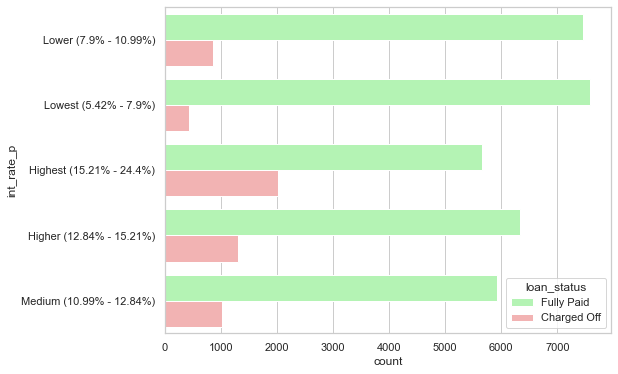

int_rate_p,Charged off %,Record count
Highest (15.21% - 24.4%),0.262150,7675
Higher (12.84% - 15.21%),0.171619,7639
Medium (10.99% - 12.84%),0.146995,6939
Lower (7.9% - 10.99%),0.102876,8311
Lowest (5.42% - 7.9%),0.053538,8013


In [160]:
PercentileCut(column='int_rate', trailer='%')
Univariate_Categorical(column='int_rate_p')

Higher the interest rate leads to higher charged off%

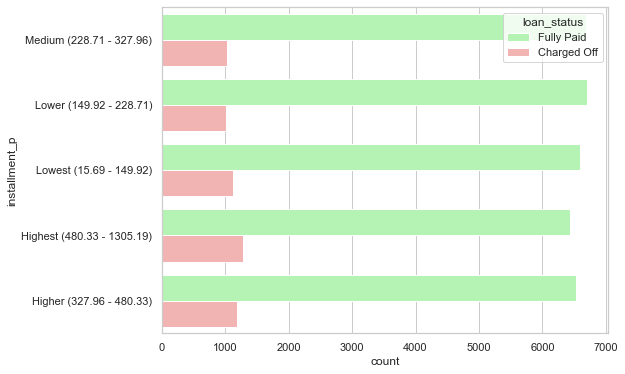

installment_p,Charged off %,Record count
Highest (480.33 - 1305.19),0.166321,7714
Higher (327.96 - 480.33),0.152988,7713
Lowest (15.69 - 149.92),0.145153,7716
Medium (228.71 - 327.96),0.132936,7718
Lower (149.92 - 228.71),0.131934,7716


In [161]:
PercentileCut(column='installment')
Univariate_Categorical(column='installment_p')

Above data and plot shows that higher installment amounts shows higher default percentages.

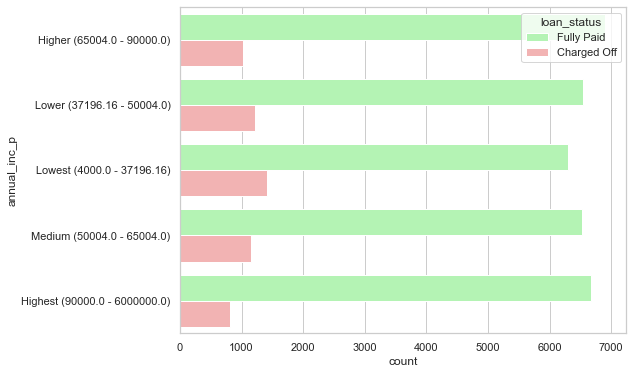

annual_inc_p,Charged off %,Record count
Lowest (4000.0 - 37196.16),0.183126,7716
Lower (37196.16 - 50004.0),0.156926,7768
Medium (50004.0 - 65004.0),0.149629,7679
Higher (65004.0 - 90000.0),0.129651,7929
Highest (90000.0 - 6000000.0),0.109285,7485


In [162]:
PercentileCut(column='annual_inc')
Univariate_Categorical(column='annual_inc_p')

Higher the income hiegher the repayment %

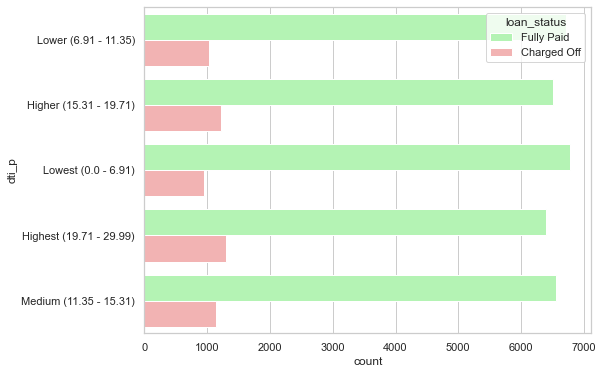

dti_p,Charged off %,Record count
Highest (19.71 - 29.99),0.168853,7699
Higher (15.31 - 19.71),0.157908,7726
Medium (11.35 - 15.31),0.147609,7696
Lower (6.91 - 11.35),0.132627,7736
Lowest (0.0 - 6.91),0.122409,7720


In [163]:
PercentileCut(column='dti')
Univariate_Categorical(column='dti_p')

higher DTI ( debt to income ratio) will lead to higher charged off %

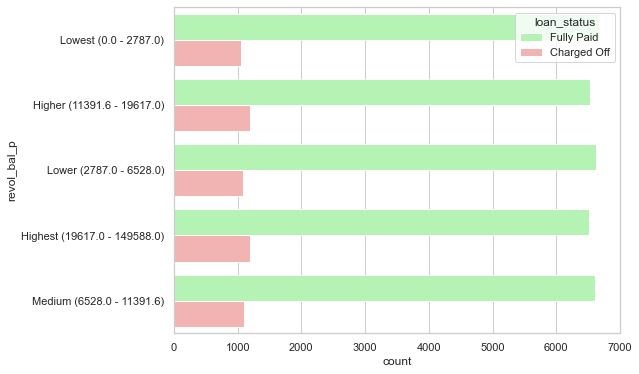

revol_bal_p,Charged off %,Record count
Highest (19617.0 - 149588.0),0.154913,7714
Higher (11391.6 - 19617.0),0.154335,7717
Medium (6528.0 - 11391.6),0.142894,7712
Lower (2787.0 - 6528.0),0.141283,7715
Lowest (0.0 - 2787.0),0.135898,7719


In [164]:
PercentileCut(column='revol_bal')
Univariate_Categorical(column='revol_bal_p')

This shows the total credit revolving balances slightly influence the default percentage. Higher the revolving balance, bigger the chance of the loan getting defaulted.

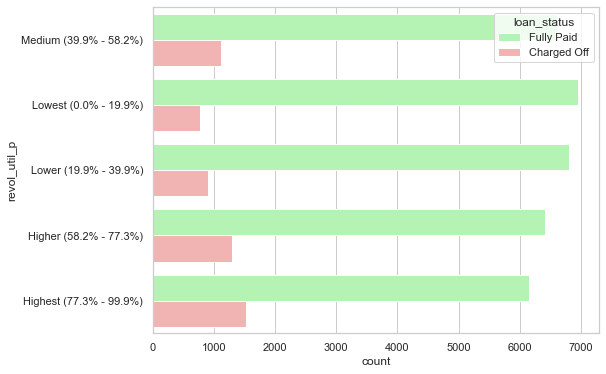

revol_util_p,Charged off %,Record count
Highest (77.3% - 99.9%),0.198069,7664
Higher (58.2% - 77.3%),0.167727,7703
Medium (39.9% - 58.2%),0.145001,7731
Lower (19.9% - 39.9%),0.118356,7714
Lowest (0.0% - 19.9%),0.099417,7715


In [165]:
PercentileCut(column='revol_util',trailer='%')
Univariate_Categorical(column='revol_util_p')

This data shows that the revolving line utilization rate has a large impact to the default percentage. When this increases, the charged off percentage rises.

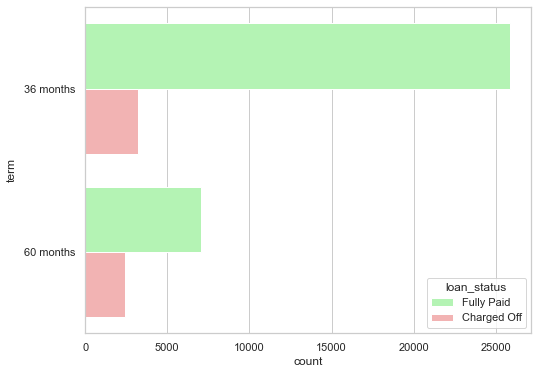

term,Charged off %,Record count
60 months,0.253138,9481
36 months,0.110909,29096


In [166]:
Univariate_Categorical(column='term')

For loans with 5 year repayment term, the default percent is 25%. And for 3 year loan repayment term, the default is only for 11% of the cases. 
Therefore, loan repayment term plays a factor in judging the default rate.

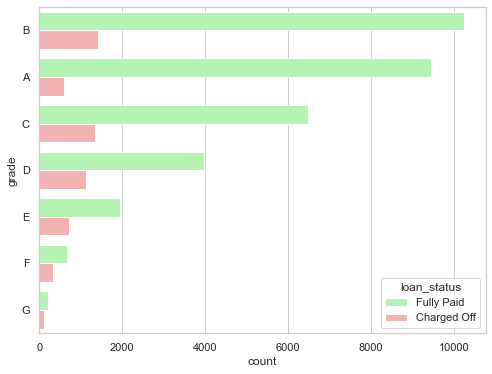

grade,Charged off %,Record count
G,0.337793,299
F,0.326844,976
E,0.268494,2663
D,0.219862,5085
C,0.171943,7834
B,0.122056,11675
A,0.059930,10045


In [167]:
Univariate_Categorical(column='grade')

We can clearly see that loan grades having highest default percentages. G, F, E and D form grades where default rate is much higher than others.


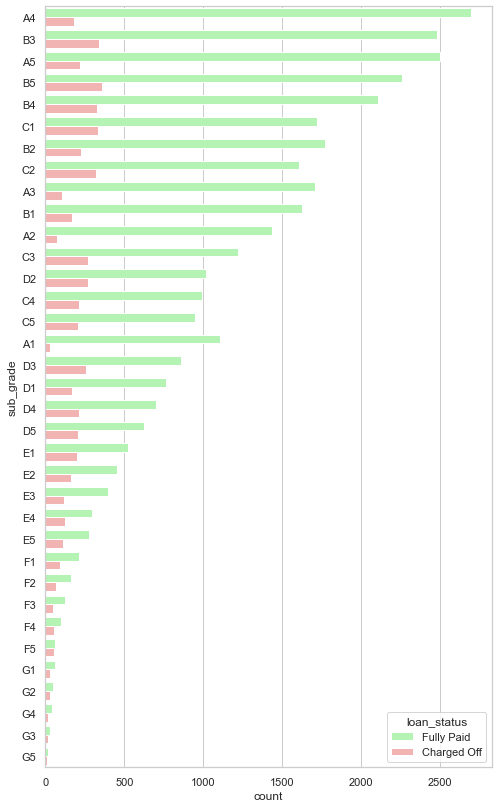

sub_grade,Charged off %,Record count
F5,0.477876,113
G3,0.422222,45
G2,0.363636,77
F4,0.350993,151
G5,0.344828,29
G1,0.329787,94
F2,0.300429,233
F1,0.298361,305
E4,0.297170,424
F3,0.293103,174


In [168]:
Univariate_Categorical(column='sub_grade', figsize=(8,14))

The above table shows the loan sub-grade versus the default percentage. The G3 and F5 sub categories have above 40% default rate. This field is a clear indicator of the default percent.

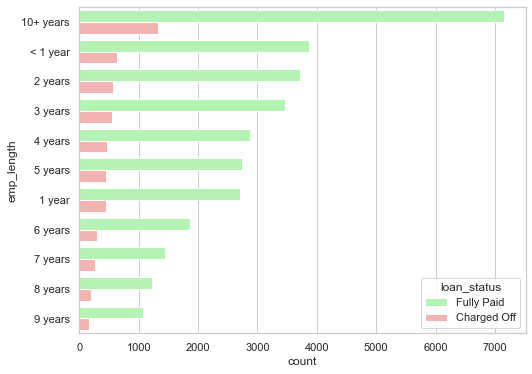

emp_length,Charged off %,Record count
10+ years,0.156810,8488
7 years,0.153711,1711
1 year,0.143894,3169
5 years,0.143394,3194
< 1 year,0.141748,4508
6 years,0.141605,2168
8 years,0.141463,1435
3 years,0.138335,4012
4 years,0.138241,3342
2 years,0.132137,4291


In [169]:
Univariate_Categorical(column='emp_length')

although there is nothing much to conclude from above data, we can see having no employment will lead to Defaulted payment

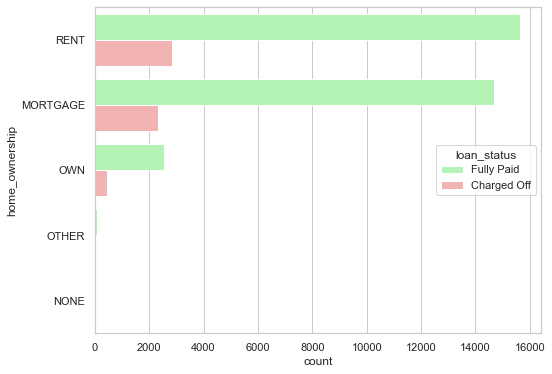

home_ownership,Charged off %,Record count
OTHER,0.183673,98
RENT,0.153626,18480
OWN,0.148908,2975
MORTGAGE,0.136713,17021


In [170]:
Univariate_Categorical(column='home_ownership')

we have not much info to conclude as it says "OTHER", 

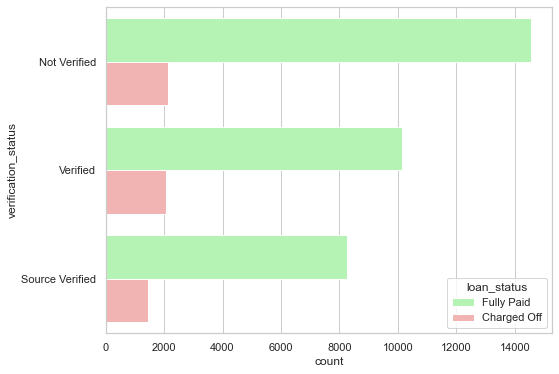

verification_status,Charged off %,Record count
Verified,0.168032,12206
Source Verified,0.148186,9677
Not Verified,0.128310,16694


In [171]:
Univariate_Categorical(column='verification_status')

interestingly verified applicants have more defaulted % which means the verifiaction process is not correct.

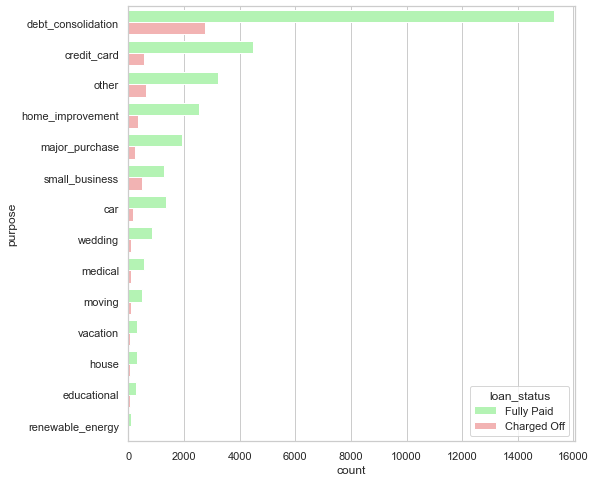

purpose,Charged off %,Record count
small_business,0.270810,1754
renewable_energy,0.186275,102
educational,0.172308,325
other,0.163777,3865
house,0.160763,367
moving,0.159722,576
medical,0.155653,681
debt_consolidation,0.153254,18055
vacation,0.141333,375
home_improvement,0.120696,2875


In [172]:
Univariate_Categorical(column='purpose', figsize=(8,8))

From the above analysis it is evidend that the loans taken for small_business, renewable_energy and educational are the riskier ones.

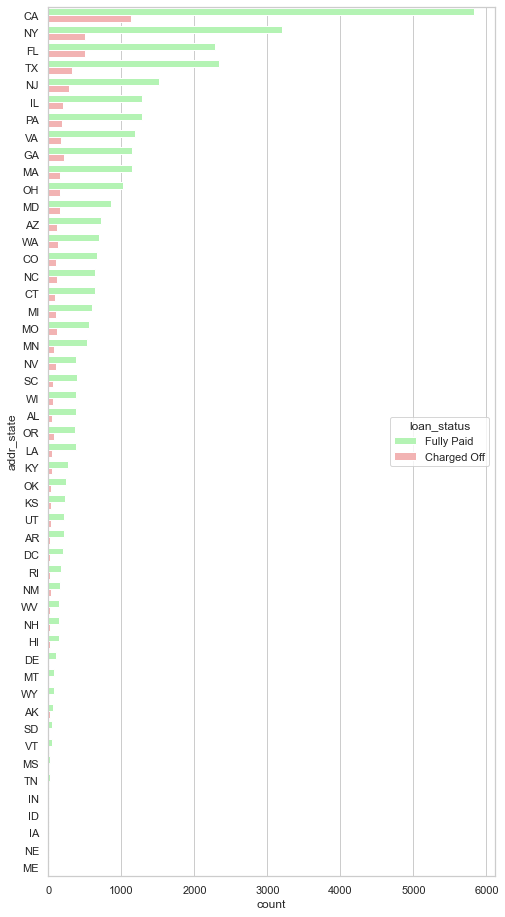

addr_state,Charged off %,Record count
NE,0.600000,5
NV,0.225470,479
SD,0.193548,62
AK,0.192308,78
FL,0.181230,2781
MO,0.170149,670
HI,0.168675,166
ID,0.166667,6
NM,0.163934,183
OR,0.163218,435


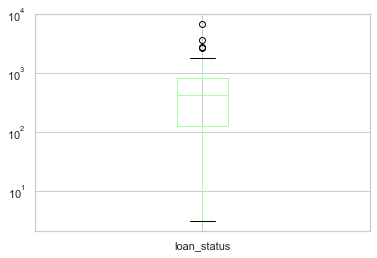

In [173]:
Univariate_Categorical(column='addr_state',figsize=(8,16), box_plot=True)

From the above table we can see that the some of the risky states are NE, NV, SD, AK, FL, MO

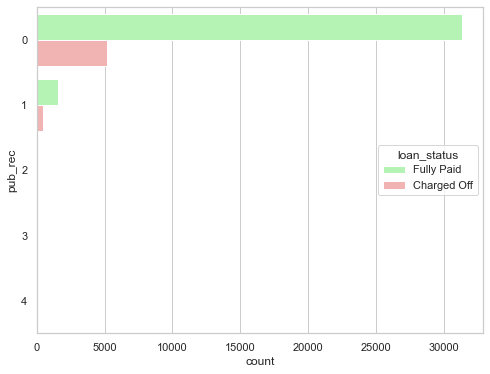

pub_rec,Charged off %,Record count
1,0.227024,2013
2,0.208333,48
0,0.141343,36507


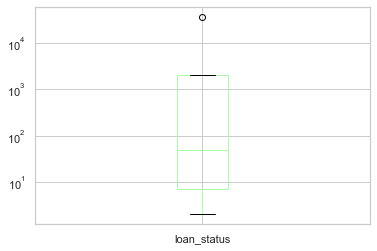

In [174]:
Univariate_Categorical(column='pub_rec', box_plot=True)

Above data and graph crealy shows that individuals with non-zero derogatory public records have higher chances of charged off

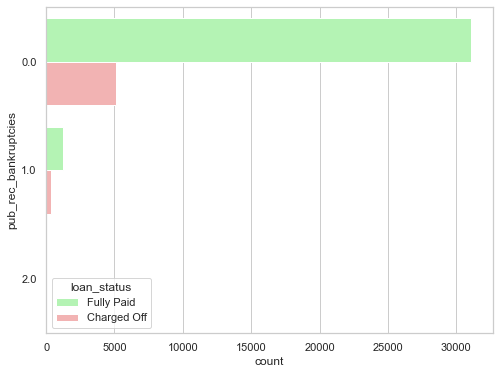

pub_rec_bankruptcies,Charged off %,Record count
2.0,0.400000,5
1.0,0.223580,1637
0.0,0.141868,36238


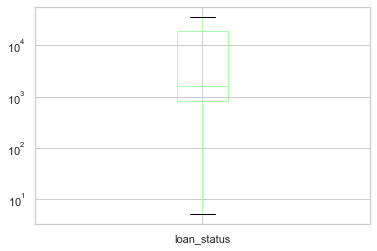

In [175]:
Univariate_Categorical(column='pub_rec_bankruptcies', box_plot=True)

Higher the number of public bankruptcy records, bigger the chance of defaulting the loan.

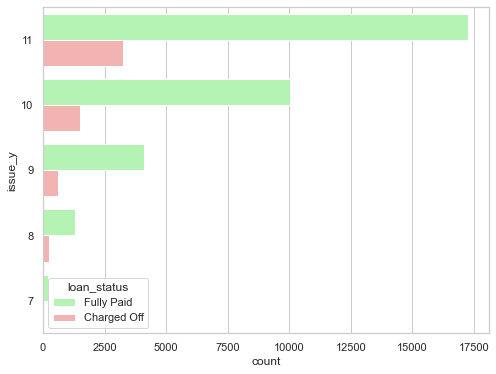

issue_y,Charged off %,Record count
7,0.179283,251
11,0.158705,20516
8,0.158131,1562
10,0.128772,11532
9,0.125954,4716


In [176]:
Univariate_Categorical(column='issue_y')

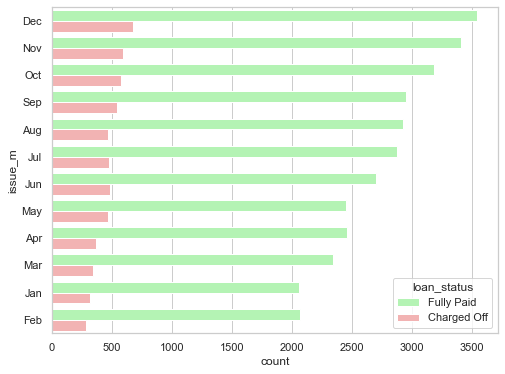

issue_m,Charged off %,Record count
Dec,0.160854,4215
May,0.159644,2919
Sep,0.156375,3498
Oct,0.154214,3761
Jun,0.151887,3180
Nov,0.149276,4006
Jul,0.142942,3351
Aug,0.138135,3388
Jan,0.134931,2379
Apr,0.130696,2831


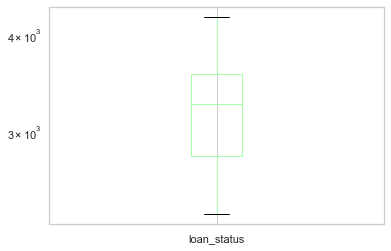

In [177]:
Univariate_Categorical(column='issue_m', box_plot=True)

we can clearly see December is the month which has the highest number of loan applications per year and also have the biggest default ratio. May be people take loan for travel/party during Christmas and then are not able to pay back. Month of May is also another one, which is during the summer break and right before the Memorial day and Independance day breaks in US where people love to travel.

# Bivariate Analysis

Now that we have analyzed each of the variables and its impact on the loan-status, let us take group of variables together and and analyze their combined effect on the loan-status. These categories are based on our business understanding. The original distribution column shows the average trend in all the data and we compare that with the data after applying our conditions.


In [178]:
def Bivariate_Analysis (*, data=loan, x, y, title=None, figsize=(8,6)):
    """
        Parameters:
            data : defaulted at the 'loan' variable, but can be changed externally if needed
            x, y : columns of data in the corresponding axis, one numerical and one categorical
            figsize : a default have is given, but can be overridden
        Returns:
            None, does a violin plot
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.violinplot(data=data, x=x, y=y, hue=by, split=True, figsize=figsize,
                   ax=ax, hue_order=order)
    if title is not None:
        plt.title(title)
    plt.show()

In [179]:
def Bivariate_Categorical (*, data=loan, x, y, title=None, figsize=(8,6)):
    """
        Parameters:
            data : defaulted at the 'loan' variable, but can be changed externally if needed
            x, y : columns of data in the corresponding axis, both categorical
            figsize : a default have is given, but can be overridden
        Returns:
            None, does a heatmap plot
    """
    fig, ax = plt.subplots(figsize=figsize)
    pt = pd.pivot_table(data=data, values='loan_status_num', index=y, columns=x)
    sns.heatmap(pt, ax=ax, cmap='YlGnBu')
    if title is not None:
        plt.title(title)
    plt.show()

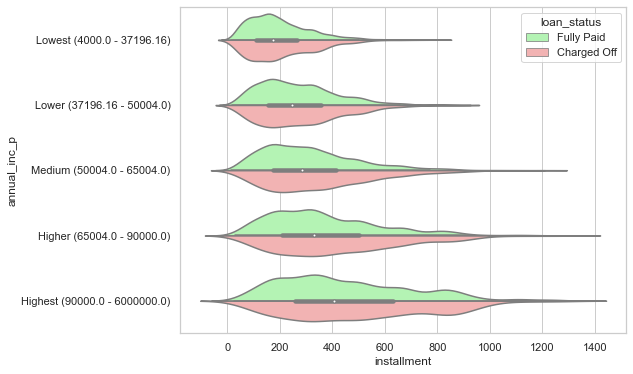

In [180]:
Bivariate_Analysis(x='installment', y='annual_inc_p')
plt.show()

Above figure shows that for higher installments for any income group have more number of defaults.

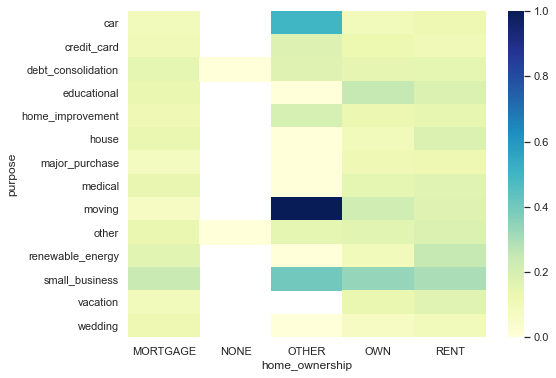

In [181]:
Bivariate_Categorical(x='home_ownership', y='purpose')

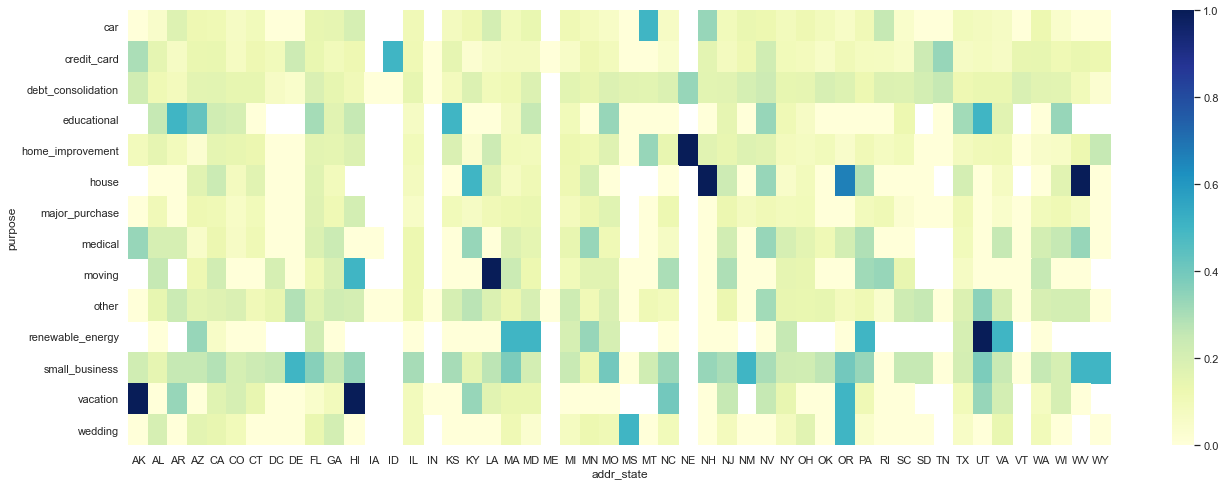

In [182]:
Bivariate_Categorical(x='addr_state', y='purpose', figsize=(22,8))

As per the above plot, the darker the intersection of addr_state has with the purpose of the loan, the risker the loan application is. Some of the examples are below:
•vacation loans in AK, HI, OR
•education loans in AR, KS, UT
•small business loans in DE, NM, WV, wY
•wedding loans in MS, OR


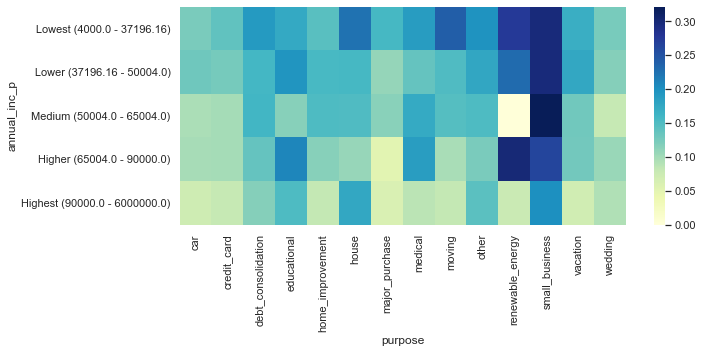

In [183]:
Bivariate_Categorical(x='purpose', y='annual_inc_p', figsize=(10,4))

Plot of various income groups versus the risky purposes of loans for them. Some examples are:
•small business loans for lowest and medium income groups
•renewable energy loans for higher income group


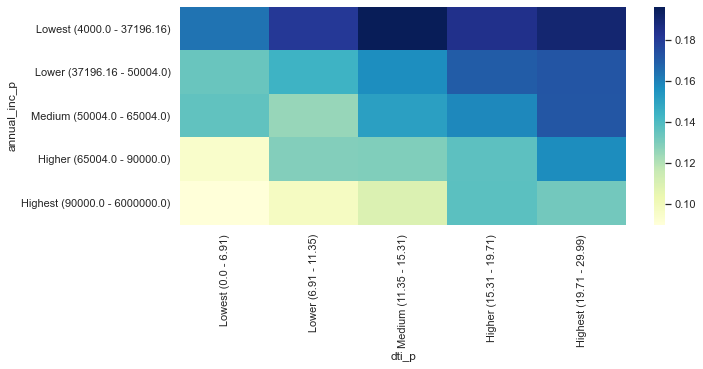

In [184]:
Bivariate_Categorical(x='dti_p', y='annual_inc_p', figsize=(10,4))

Medium debt-to-income group in the lowest income range is the most risky when it comes to loan repayment.

 Hereby we come to an end of the EDA of the loan data set and finding some of the drivers for loan default. Apart from the ones highlighted below, I am sure there will be multiple others too; however, according to me, these are the most impactful ones.

<b>Minor Impact</b> <br>
.Higher loan amount (above 16K) <br>
•Higher installment amount (above 327) <br>
•Lower annual income (below 37K)<br> 
•Higher debt to income ratio (above 15%) <br>
•Applicant’s address state (NV, SD, AK, FL, etc.) <br>
•Loan issue month (Dec, May, Sep)<br>

<b>Heavy impact</b> <br>
•Higher interest rate (above 13%) <br>
•Higher revolving line utilization rate (above 58%) <br>
•Repayment term (5 years)<br> 
•Loan grade & sub-grade (D to G) <br>
•Missing employment record<br> 
•Loan purpose (small business, renewable energy, educational) <br>
•Derogatory public records (1 or 2) <br>
•Public bankruptcy records (1 or 2)<br>

<b>Combined impact</b> <br>
•High loan amount & interest rate for lower income group <br>
•High installment and longer repayment term <br>
•Home ownership (other) and loan purpose (car, moving or small business) <br>
•Residential state and loan purpose<br> 
•Income group and loan purpose<br>
